In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2, os
import argparse

from tqdm import tqdm

from tensorflow.keras import layers, models
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import Activation, Dropout,BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras.utils
# import tensorflow.keras.optimizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

In [3]:
os.listdir()

['Untitled.ipynb',
 'covid-chestxray-dataset-master.zip',
 'course',
 'FFNN_Covid19_Xray_V1.h5',
 '.ipynb_checkpoints',
 'stringreversal.py',
 'Project.ipynb',
 'CNN_Covid19_Xray_V1.h5',
 'studies.txt',
 'links.txt',
 'COVID-19_Radiography_Dataset']

In [4]:
os.listdir('COVID-19_Radiography_Dataset')

['COVID', 'Normal', 'Viral Pneumonia', 'Lung_Opacity']

In [78]:
imagePaths = []
for dirname, _, filenames in os.walk('COVID-19_Radiography_Dataset'):

    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [79]:
Data = []
Target = []
resize = 150
size=[]
imagePaths = imagePaths[::15]
cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19',
       'Lung_Opacity': 'Lung Opacity'}

for imagePath in tqdm(imagePaths):
    size.append(plt.imread(imagePath).shape)
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255
    Data.append(image)
    Target.append(cat[label])

100%|██████████| 1411/1411 [00:25<00:00, 56.02it/s]


In [80]:
# plt.figure(figsize=(20,20))
# img= cv2.imread(imagePaths[0])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(image, (resize, resize))/255

# plt.imshow(img)

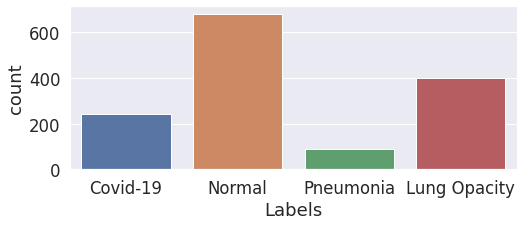

Covid-19: 242
Normal: 679
Pneumonia:  90
Lung Opacity: 400


In [81]:
df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(x = df['Labels'])
sns.set(rc={'figure.figsize':(8,3)})
plt.show()
print('Covid-19:',Target.count('Covid-19'))
print('Normal:',Target.count('Normal'))
print('Pneumonia: ',Target.count('Pneumonia'))
print('Lung Opacity:',Target.count('Lung Opacity'))


In [82]:
pd.Series(size).value_counts()

(299, 299)       1401
(299, 299, 3)      10
dtype: int64

In [83]:
Data[1][1][1]

array([0.18823529, 0.18823529, 0.18823529])

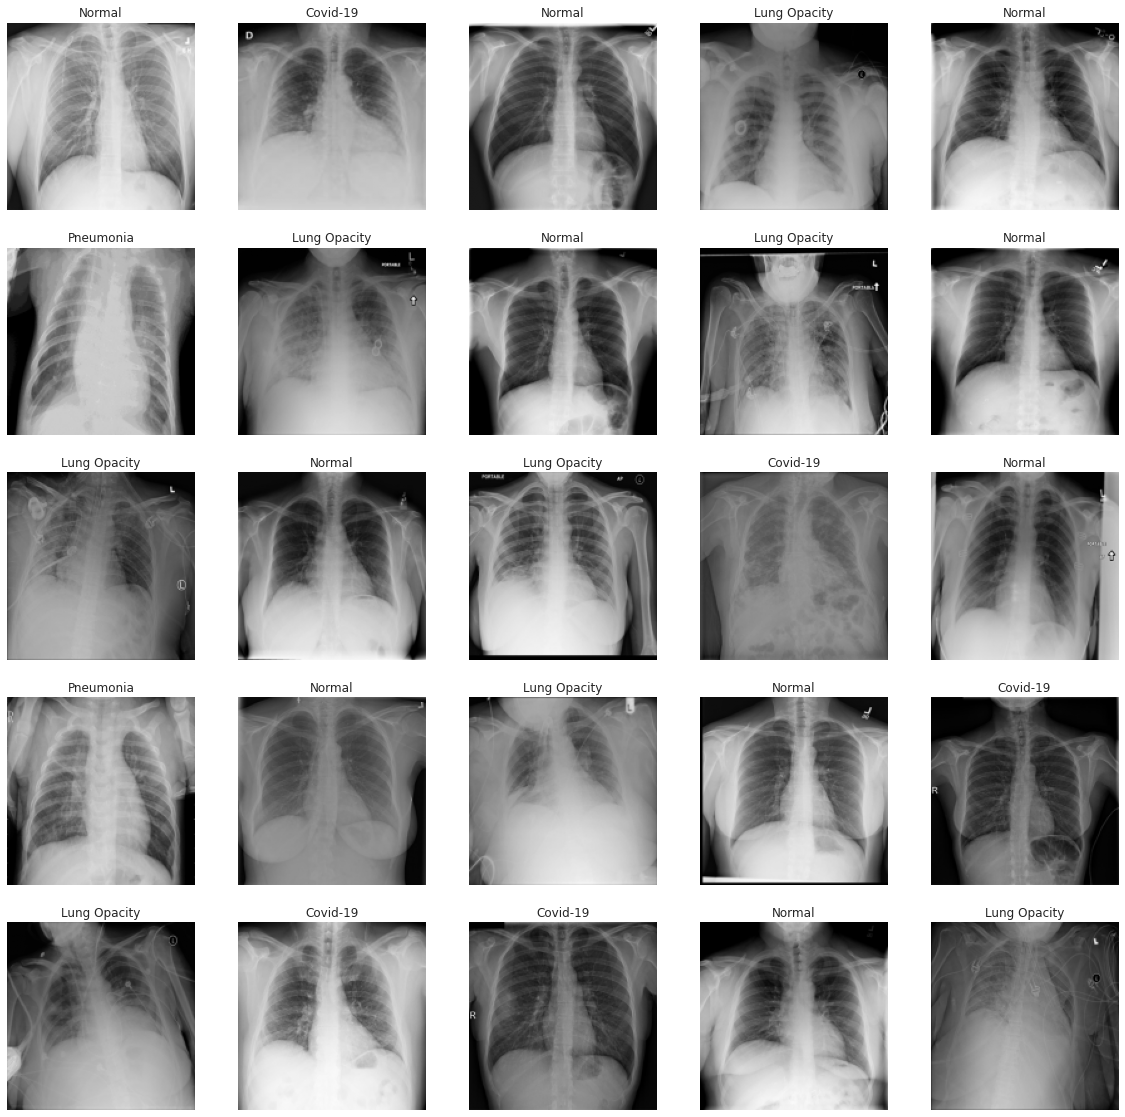

In [84]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) :
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

In [85]:
le = LabelEncoder()
labels = le.fit_transform(Target)
print(labels)
labels = to_categorical(labels)
print(le.classes_)
print(labels)

[0 0 0 ... 1 1 1]
['Covid-19' 'Lung Opacity' 'Normal' 'Pneumonia']
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [86]:
(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=42)
(x_train, x_val, y_train, y_val) = train_test_split(x_train,y_train,test_size=0.2,random_state=42)
    
trainX = np.array(x_train)
testX = np.array(x_test)
trainY = np.array(y_train)
testY = np.array(y_test)
valX = np.array(x_val)
valY = np.array(y_val)

print(trainX.shape)
print(testX.shape)
print(valX.shape)
print(trainY.shape)
print(testY.shape)
print(valY.shape)

(902, 150, 150, 3)
(283, 150, 150, 3)
(226, 150, 150, 3)
(902, 4)
(283, 4)
(226, 4)


## CNN convolutional neural network (keras)

In [87]:
s=150
batch_size = 50
epochs = 50



In [88]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(s,s,3), kernel_initializer='he_normal',))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))

model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation = "softmax"))

In [89]:
model.compile(optimizer = 'adam',
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy']
             )


In [90]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 33, 33, 128)      

In [91]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    mode = 'auto',
    min_delta = 0,
    patience = 3,
    verbose = 1,
    restore_best_weights = True
)

In [92]:
CNNmodel = model.fit(trainX,
                     trainY, 
                     epochs=epochs,
                     callbacks = [early_stopping],
                     validation_data = (valX,valY),
                     batch_size=batch_size,
                     verbose=1
)

Epoch 1/50
19/19 [==============================] - 24s 1s/step - loss: 7.8280 - accuracy: 0.3977 - val_loss: 1.3775 - val_accuracy: 0.4115
Epoch 2/50
19/19 [==============================] - 30s 2s/step - loss: 0.9526 - accuracy: 0.6069 - val_loss: 1.3514 - val_accuracy: 0.5000
Epoch 3/50
19/19 [==============================] - 32s 2s/step - loss: 0.8308 - accuracy: 0.6623 - val_loss: 1.2815 - val_accuracy: 0.5354
Epoch 4/50
19/19 [==============================] - 31s 2s/step - loss: 0.7841 - accuracy: 0.6804 - val_loss: 1.2297 - val_accuracy: 0.5796
Epoch 5/50
19/19 [==============================] - 32s 2s/step - loss: 0.6338 - accuracy: 0.7397 - val_loss: 1.1913 - val_accuracy: 0.5133
Epoch 6/50
19/19 [==============================] - 36s 2s/step - loss: 0.5608 - accuracy: 0.7783 - val_loss: 1.0828 - val_accuracy: 0.5841
Epoch 7/50
19/19 [==============================] - 36s 2s/step - loss: 0.3990 - accuracy: 0.8451 - val_loss: 1.0102 - val_accuracy: 0.6150
Epoch 8/50
19/19 [==

In [93]:
modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))



Test Loss is 0.7150410413742065
Test Accuracy is 0.7067137956619263


In [94]:
class_names = ['Covid-19','Lung Opacity','Normal','Pneumonia']
y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[110])])


Normal


In [95]:
# classification report on train
predIdxs = model.predict(trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.87500   0.88079   0.87789       151
Lung Opacity    0.91915   0.84375   0.87984       256
      Normal    0.90476   0.91096   0.90785       438
   Pneumonia    0.75676   0.98246   0.85496        57

    accuracy                        0.89135       902
   macro avg    0.86392   0.90449   0.88013       902
weighted avg    0.89451   0.89135   0.89154       902



In [96]:
# classification report on test

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.50980   0.53061   0.52000        49
Lung Opacity    0.78125   0.62500   0.69444        80
      Normal    0.73793   0.78676   0.76157       136
   Pneumonia    0.73913   0.94444   0.82927        18

    accuracy                        0.70671       283
   macro avg    0.69203   0.72171   0.70132       283
weighted avg    0.71075   0.70671   0.70507       283



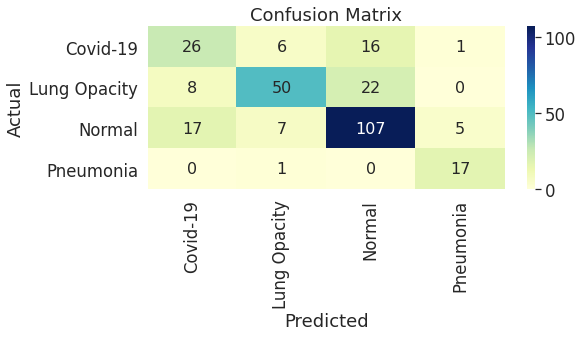

In [97]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x,index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

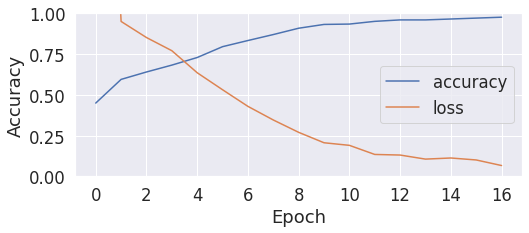

In [98]:
plt.plot(CNNmodel.history['accuracy'], label='accuracy')
plt.plot(CNNmodel.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='center right')


In [124]:
model.save('CNN_Covid19_Xray_V1.h5') 

## Feed Forward Neural Network

In [125]:
modelFFNN = Sequential()
modelFFNN.add(Flatten())
modelFFNN.add(Dense(512, input_shape=trainX.shape, activation="sigmoid"))
modelFFNN.add(Dense(256, activation="sigmoid"))
modelFFNN.add(Dense(4, activation="softmax"))
modelFFNN.build(input_shape = trainX.shape)
modelFFNN.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (847, 67500)              0         
_________________________________________________________________
dense_43 (Dense)             (847, 512)                34560512  
_________________________________________________________________
dense_44 (Dense)             (847, 256)                131328    
_________________________________________________________________
dense_45 (Dense)             (847, 4)                  1028      
Total params: 34,692,868
Trainable params: 34,692,868
Non-trainable params: 0
_________________________________________________________________


In [126]:
trainY

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [127]:
# train the model using SGD
print("[INFO] compiling model...")
sgd = SGD(lr=0.01)
modelFFNN.compile(loss="binary_crossentropy", optimizer=sgd,metrics=["accuracy"])
modelFFNN.fit(trainX, trainY, epochs=epochs, batch_size=batch_size,verbose=1)

[INFO] compiling model...
Epoch 1/50
17/17 [==============================] - 4s 179ms/step - loss: 0.7047 - accuracy: 0.3041
Epoch 2/50
17/17 [==============================] - 5s 259ms/step - loss: 0.5076 - accuracy: 0.4773
Epoch 3/50
17/17 [==============================] - 4s 252ms/step - loss: 0.4907 - accuracy: 0.5041
Epoch 4/50
17/17 [==============================] - 3s 198ms/step - loss: 0.4906 - accuracy: 0.4902
Epoch 5/50
17/17 [==============================] - 3s 175ms/step - loss: 0.4856 - accuracy: 0.4876
Epoch 6/50
17/17 [==============================] - 4s 251ms/step - loss: 0.4919 - accuracy: 0.4586
Epoch 7/50
17/17 [==============================] - 4s 256ms/step - loss: 0.4806 - accuracy: 0.4941
Epoch 8/50
17/17 [==============================] - 4s 253ms/step - loss: 0.4784 - accuracy: 0.4888
Epoch 9/50
17/17 [==============================] - 4s 247ms/step - loss: 0.4903 - accuracy: 0.4590
Epoch 10/50
17/17 [==============================] - 4s 238ms/step - loss:

In [128]:
modelLoss, modelAccuracy = modelFFNN.evaluate(testX, testY, verbose=1)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))


7/7 [==============================] - 1s 128ms/step - loss: 0.4177 - accuracy: 0.6085
Test Loss is 0.4177079498767853
Test Accuracy is 0.6084905862808228


In [129]:
class_names = ['COVID-19','Normal','Viral Pneumonia','Lung Opacity']
y_pred = modelFFNN.predict(testX)
print(class_names[np.argmax(y_pred[110])])

Viral Pneumonia


In [130]:
# classification report on train

predIdxs = modelFFNN.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.00000   0.00000   0.00000       145
Lung Opacity    0.58369   0.56432   0.57384       241
      Normal    0.62866   0.94608   0.75538       408
   Pneumonia    0.00000   0.00000   0.00000        53

    accuracy                        0.61629       847
   macro avg    0.30309   0.37760   0.33231       847
weighted avg    0.46891   0.61629   0.52714       847



/home/ritesh/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritesh/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritesh/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [131]:
# classification report on test

predIdxs = modelFFNN.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.00000   0.00000   0.00000        36
Lung Opacity    0.60714   0.56667   0.58621        60
      Normal    0.60897   0.93137   0.73643       102
   Pneumonia    0.00000   0.00000   0.00000        14

    accuracy                        0.60849       212
   macro avg    0.30403   0.37451   0.33066       212
weighted avg    0.46483   0.60849   0.52023       212



/home/ritesh/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritesh/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ritesh/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


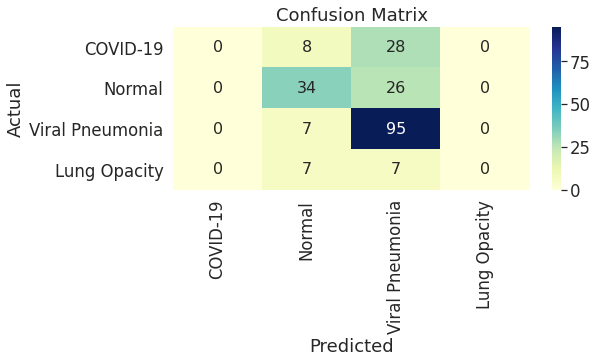

In [132]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x,index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [139]:
modelFFNN.save('FFNN_Covid19_Xray_V1.h5') 

## RNN

In [140]:
trainX1 = np.reshape(trainX,(trainX.shape[0], trainX.shape[1],trainX.shape[2]*trainX.shape[3]))


In [141]:
modelRNN = Sequential()
modelRNN.add(
    layers.Bidirectional(layers.LSTM(512, return_sequences=True))
)
modelRNN.add(SimpleRNN(256, return_sequences=True))
modelRNN.add(GRU(128))
modelRNN.add(Dense(4))
modelRNN.build(input_shape = trainX1.shape)

In [142]:
modelRNN.compile(optimizer = keras.optimizers.SGD(lr=0.01),
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])


In [143]:
modelRNN.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (847, 150, 1024)          3944448   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (847, 150, 256)           327936    
_________________________________________________________________
gru_1 (GRU)                  (847, 128)                148224    
_________________________________________________________________
dense_47 (Dense)             (847, 4)                  516       
Total params: 4,421,124
Trainable params: 4,421,124
Non-trainable params: 0
_________________________________________________________________


In [ ]:
RNNmodel = modelRNN.fit(
    trainX1, trainY, batch_size=batch_size, epochs=epochs, verbose =1
)


Epoch 1/50
17/17 [==============================] - 112s 6s/step - loss: 7.2600 - accuracy: 0.2198
Epoch 2/50
17/17 [==============================] - 104s 6s/step - loss: 7.4457 - accuracy: 0.1616
Epoch 3/50
17/17 [==============================] - 102s 6s/step - loss: 7.0828 - accuracy: 0.1753
Epoch 4/50
17/17 [==============================] - 104s 6s/step - loss: 7.1199 - accuracy: 0.1886
Epoch 5/50
17/17 [==============================] - 104s 6s/step - loss: 6.9893 - accuracy: 0.1743
Epoch 6/50
17/17 [==============================] - 108s 6s/step - loss: 7.2125 - accuracy: 0.1812
Epoch 7/50
17/17 [==============================] - 115s 7s/step - loss: 7.2550 - accuracy: 0.1589
Epoch 8/50
17/17 [==============================] - 104s 6s/step - loss: 6.9322 - accuracy: 0.1896
Epoch 9/50
17/17 [==============================] - 101s 6s/step - loss: 7.0247 - accuracy: 0.1851
Epoch 10/50
17/17 [==============================] - 101s 6s/step - loss: 7.1006 - accuracy: 0.1686
Epoch 11/

In [ ]:
modelLoss, modelAccuracy = modelRNN.evaluate(testX, testY, verbose=1)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))


In [ ]:
# classification report on train

predIdxs = modelRNN.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

In [ ]:
# classification report on test

predIdxs = modelRNN.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

In [ ]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x,index=class_names, columns=class_names)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()